In [1]:
options(warn = -1)

In [2]:
df <- read.csv('cut_taxi_dataset10000.csv')
df_2 <- read.csv('student_health_data.csv')

In [3]:
library(stats)
library(dplyr)


Присоединяю пакет: ‘dplyr’


Следующие объекты скрыты от ‘package:stats’:

    filter, lag


Следующие объекты скрыты от ‘package:base’:

    intersect, setdiff, setequal, union




In [4]:
install.packages("corrplot")

Обновляю HTML-список пакетов в '.Library'

Making 'packages.html' ...
 готово



#### 1 Задание
Продемонстрировать применение для проверки различных гипотез и
различных доверительных уровней (0.9, 0.95, 0.99) следующих критериев:
a.
Стьюдента, включая односторонние варианты, когда
проверяемая нулевая гипотеза заключается в том, что одно из сравниваемыхсредних значений больше (или меньше) другого. Реализовать оценку
мощности критериев при заданном объеме выборки или определения
объема выборки для достижения заданной мощности;
b.
Уилкоксона-Манна-Уитни (ранговые);
c.
Фишера, Левене, Бартлетта, Флигнера-Килина (проверка
гипотез об однородности дисперсий).

In [5]:
alpha_levels <- c(0.1, 0.04, 0.01) # уровни значимости
trips_per_day <- read.csv('trips_per_day.csv') 
str(trips_per_day)

'data.frame':	31 obs. of  3 variables:
 $ X         : int  0 1 2 3 4 5 6 7 8 9 ...
 $ date      : chr  "2015-01-01" "2015-01-02" "2015-01-03" "2015-01-04" ...
 $ trip_count: int  310 300 337 268 272 313 331 353 360 412 ...


In [6]:
# Колмогоров-Смирнов тест на нормальность
ks_stat <- ks.test(
  trips_per_day$trip_count,
  "pnorm",
  mean = mean(trips_per_day$trip_count),
  sd = sd(trips_per_day$trip_count)
)
cat(sprintf("Kolmogorov-Smirnov test: Stat=%.4f, p-value=%.4f\n", ks_stat$statistic, ks_stat$p.value))


Kolmogorov-Smirnov test: Stat=0.2315, p-value=0.0720


In [7]:
# Разделение данных на две группы
group_1 <- trips_per_day %>%
  filter(X <= 14) %>%
  pull(trip_count)

group_2 <- trips_per_day %>%
  filter(X > 14) %>%
  pull(trip_count)

# Критерий Стьюдента для независимых выборок
# Двусторонний тест
t_test_2 <- t.test(group_1, group_2, var.equal = FALSE)
cat(sprintf("Двусторонний тест: t-статистика: %.2f, p-значение: %.4f\n", t_test_2$statistic, t_test_2$p.value))

# Односторонний тест (H0: mean(group_1) <= mean(group_2))
t_test_1 <- t.test(group_1, group_2, alternative = "less", var.equal = FALSE)
cat(sprintf("Односторонний тест (mean(group_1) <= mean(group_2)): t-статистика: %.2f, p-значение: %.4f\n", t_test_1$statistic, t_test_1$p.value))

# Проверка доверительных уровней
for (alpha in alpha_levels) {
  cat(sprintf("\nДоверительный уровень: %.2f\n", 1 - alpha))
  
  # Двусторонний тест
  cat("Двусторонний тест:\n")
  if (t_test_2$p.value < alpha) {
    cat("Отвергаем нулевую гипотезу\n")
  } else {
    cat("Не отвергаем нулевую гипотезу\n")
  }
  
  # Односторонний тест
  cat("Односторонний тест:\n")
  if (t_test_1$p.value < alpha) {
    cat("Отвергаем нулевую гипотезу\n")
  } else {
    cat("Не отвергаем нулевую гипотезу\n")
  }
}

Двусторонний тест: t-статистика: 0.49, p-значение: 0.6262
Односторонний тест (mean(group_1) <= mean(group_2)): t-статистика: 0.49, p-значение: 0.6869

Доверительный уровень: 0.90
Двусторонний тест:
Не отвергаем нулевую гипотезу
Односторонний тест:
Не отвергаем нулевую гипотезу

Доверительный уровень: 0.96
Двусторонний тест:
Не отвергаем нулевую гипотезу
Односторонний тест:
Не отвергаем нулевую гипотезу

Доверительный уровень: 0.99
Двусторонний тест:
Не отвергаем нулевую гипотезу
Односторонний тест:
Не отвергаем нулевую гипотезу


In [8]:
install.packages('pwr')

Обновляю HTML-список пакетов в '.Library'

Making 'packages.html' ...
 готово



In [9]:
library(pwr)  # Для оценки мощности


# Уровни значимости
alpha_levels <- c(0.1, 0.04, 0.01)

# 2. Критерий Уилкоксона-Манна-Уитни
wilcox_test <- wilcox.test(group_1, group_2, alternative = "two.sided")
stat <- wilcox_test$statistic
p_value <- wilcox_test$p.value

cat(sprintf("Критерий Уилкоксона-Манна-Уитни: стат=%.2f, p=%.4f\n", stat, p_value))

for (alpha in alpha_levels) {
  cat(sprintf("\nДоверительный уровень: %.2f\n", 1 - alpha))
  if (p_value < alpha) {
    cat("Отвергаем нулевую гипотезу (различия между группами значимы)\n")
  } else {
    cat("Не отвергаем нулевую гипотезу\n")
  }
}
cat("\n")

# 3. Проверка равенства дисперсий
# Критерий Левена вручную
levene_test_manual <- function(values, groups) {
  group_means <- tapply(values, groups, mean)
  deviations <- abs(values - group_means[groups])
  aov_result <- aov(deviations ~ groups)
  return(aov_result)
}

all_values <- c(group_1, group_2)
all_groups <- factor(c(rep(1, length(group_1)), rep(2, length(group_2))))

levene_result <- levene_test_manual(all_values, all_groups)
levene_p <- summary(levene_result)[[1]]["groups", "Pr(>F)"]

bartlett_test <- bartlett.test(list(group_1, group_2))
bartlett_stat <- bartlett_test$statistic
bartlett_p <- bartlett_test$p.value

fligner_test <- fligner.test(c(group_1, group_2), 
                             factor(c(rep(1, length(group_1)), rep(2, length(group_2)))))
fligner_stat <- fligner_test$statistic
fligner_p <- fligner_test$p.value

cat(sprintf("Критерий Левена: p=%.4f\n", levene_p))
cat(sprintf("Критерий Бартлетта: стат=%.2f, p=%.4f\n", bartlett_stat, bartlett_p))
cat(sprintf("Критерий Флигнера-Килина: стат=%.2f, p=%.4f\n", fligner_stat, fligner_p))

for (alpha in alpha_levels) {
  cat(sprintf("\nДоверительный уровень: %.2f\n", 1 - alpha))
  
  cat("Критерий Левена:\n")
  if (levene_p < alpha) {
    cat("Отвергаем нулевую гипотезу\n")
  } else {
    cat("Не отвергаем нулевую гипотезу\n")
  }
  
  cat("Критерий Бартлетта:\n")
  if (bartlett_p < alpha) {
    cat("Отвергаем нулевую гипотезу\n")
  } else {
    cat("Не отвергаем нулевую гипотезу\n")
  }
  
  cat("Критерий Флигнера-Килина:\n")
  if (fligner_p < alpha) {
    cat("Отвергаем нулевую гипотезу\n")
  } else {
    cat("Не отвергаем нулевую гипотезу\n")
  }
}

# 4. Оценка мощности критерия Стьюдента
# Зададим параметры: размер выборки, эффект, стандартное отклонение
effect_size <- abs(mean(group_1) - mean(group_2)) / 
  sqrt((var(group_1) + var(group_2)) / 2)

# Мощность критерия
power <- pwr.t.test(d = effect_size, 
                    n = length(group_1), 
                    sig.level = 0.05, 
                    type = "two.sample", 
                    alternative = "two.sided")$power
cat(sprintf("\nМощность критерия Стьюдента: %.2f\n", power))

# Необходимый размер выборки для мощности 0.8
sample_size <- pwr.t.test(d = effect_size, 
                          power = 0.8, 
                          sig.level = 0.05, 
                          type = "two.sample", 
                          alternative = "two.sided")$n
cat(sprintf("Необходимый объем выборки для мощности 0.8: %.0f\n", ceiling(sample_size)))

Критерий Уилкоксона-Манна-Уитни: стат=93.00, p=0.2948

Доверительный уровень: 0.90
Не отвергаем нулевую гипотезу

Доверительный уровень: 0.96
Не отвергаем нулевую гипотезу

Доверительный уровень: 0.99
Не отвергаем нулевую гипотезу

Критерий Левена: p=0.0530
Критерий Бартлетта: стат=8.15, p=0.0043
Критерий Флигнера-Килина: стат=0.02, p=0.8792

Доверительный уровень: 0.90
Критерий Левена:
Отвергаем нулевую гипотезу
Критерий Бартлетта:
Отвергаем нулевую гипотезу
Критерий Флигнера-Килина:
Не отвергаем нулевую гипотезу

Доверительный уровень: 0.96
Критерий Левена:
Не отвергаем нулевую гипотезу
Критерий Бартлетта:
Отвергаем нулевую гипотезу
Критерий Флигнера-Килина:
Не отвергаем нулевую гипотезу

Доверительный уровень: 0.99
Критерий Левена:
Не отвергаем нулевую гипотезу
Критерий Бартлетта:
Отвергаем нулевую гипотезу
Критерий Флигнера-Килина:
Не отвергаем нулевую гипотезу

Мощность критерия Стьюдента: 0.08
Необходимый объем выборки для мощности 0.8: 510


#### 2 Задание
Исследовать корреляционные взаимосвязи в данных с помощью
коэффициентов корреляции Пирсона, Спирмена и Кендалла.

In [10]:
set.seed(42)

# Генерация данных
X <- rnorm(200)
Y <- X * 2 + rnorm(200, sd = 0.5)
Z <- rnorm(200)
W <- exp(X) + rnorm(200, sd = 0.2)

data <- data.frame(X = X, Y = Y, Z = Z, W = W)

# Корреляционные матрицы
pearson_corr <- cor(data, method = "pearson")
spearman_corr <- cor(data, method = "spearman")
kendall_corr <- cor(data, method = "kendall")

cat("Корреляционная матрица (Пирсон):\n")
print(pearson_corr)
cat("\nКорреляционная матрица (Спирмен):\n")
print(spearman_corr)
cat("\nКорреляционная матрица (Кендалл):\n")
print(kendall_corr)

# Вывод коэффициентов между переменными
pairs <- list(c("X", "Y"), c("X", "Z"), c("X", "W"), c("Y", "Z"), c("Y", "W"), c("Z", "W"))
cat("\nКоэффициенты корреляции между переменными:\n")
for (pair in pairs) {
  x <- pair[1]
  y <- pair[2]
  pearson_coef <- cor(data[[x]], data[[y]], method = "pearson")
  spearman_coef <- cor(data[[x]], data[[y]], method = "spearman")
  kendall_coef <- cor(data[[x]], data[[y]], method = "kendall")
  cat(sprintf("%s и %s: Пирсон=%.2f, Спирмен=%.2f, Кендалл=%.2f\n", 
              x, y, pearson_coef, spearman_coef, kendall_coef))
}


Корреляционная матрица (Пирсон):
            X           Y           Z           W
X  1.00000000  0.97082824 -0.05346177  0.80033053
Y  0.97082824  1.00000000 -0.03729589  0.78275564
Z -0.05346177 -0.03729589  1.00000000 -0.03008194
W  0.80033053  0.78275564 -0.03008194  1.00000000

Корреляционная матрица (Спирмен):
            X           Y           Z           W
X  1.00000000  0.96682667 -0.02470862  0.96378909
Y  0.96682667  1.00000000 -0.01344934  0.92581715
Z -0.02470862 -0.01344934  1.00000000 -0.03692492
W  0.96378909  0.92581715 -0.03692492  1.00000000

Корреляционная матрица (Кендалл):
            X            Y            Z           W
X  1.00000000  0.847135678 -0.017386935  0.84944724
Y  0.84713568  1.000000000 -0.009447236  0.76592965
Z -0.01738693 -0.009447236  1.000000000 -0.02502513
W  0.84944724  0.765929648 -0.025025126  1.00000000

Коэффициенты корреляции между переменными:
X и Y: Пирсон=0.97, Спирмен=0.97, Кендалл=0.85
X и Z: Пирсон=-0.05, Спирмен=-0.02, Кендалл=-0

In [11]:
numeric_columns <- df[,sapply(df, is.numeric)]

var1 <- "total_amount"
var2 <- "trip_distance"

pearson_corr <- cor(numeric_columns[[var1]], numeric_columns[[var2]], method = "pearson")
spearman_corr <- cor(numeric_columns[[var1]], numeric_columns[[var2]], method = "spearman")
kendall_corr <- cor(numeric_columns[[var1]], numeric_columns[[var2]], method = "kendall")

cat(sprintf("Корреляция между %s и %s:\n", var1, var2))
cat(sprintf("Пирсон: %.2f\n", pearson_corr))
cat(sprintf("Спирмен: %.2f\n", spearman_corr))
cat(sprintf("Кендалл: %.2f\n", kendall_corr))

Корреляция между total_amount и trip_distance:
Пирсон: 0.91
Спирмен: 0.91
Кендалл: 0.77


In [12]:
var1 <- 'fare_amount'
var2 <- 'passenger_count'

pearson_corr <- cor(numeric_columns[[var1]], numeric_columns[[var2]], method = "pearson")
spearman_corr <- cor(numeric_columns[[var1]], numeric_columns[[var2]], method = "spearman")
kendall_corr <- cor(numeric_columns[[var1]], numeric_columns[[var2]], method = "kendall")

cat(sprintf("Корреляция между %s и %s:\n", var1, var2))
cat(sprintf("Пирсон: %.2f\n", pearson_corr))
cat(sprintf("Спирмен: %.2f\n", spearman_corr))
cat(sprintf("Кендалл: %.2f\n", kendall_corr))

Корреляция между fare_amount и passenger_count:
Пирсон: 0.03
Спирмен: 0.02
Кендалл: 0.02


#### 3 Задание
Продемонстрировать использование методов хи-квадрат, точного
теста Фишера, теста МакНемара, Кохрана-Мантеля-Хензеля.

In [13]:
if (!require("dplyr")) install.packages("dplyr")
if (!require("stats")) install.packages("stats")

library(dplyr)

# Функция для Хи-квадрат теста
chi2f <- function(var1, var2, data) {
  # Создание таблицы сопряженности
  contingency_table <- table(data[[var1]], data[[var2]])
  
  # Хи-квадрат тест
  test <- chisq.test(contingency_table)
  
  cat("Хи-квадрат тест:\n")
  cat(sprintf("Chi2: %.2f, p-value: %.4f, dof: %d\n", test$statistic, test$p.value, test$parameter))
  
  if (test$p.value < 0.05) {
    cat(sprintf("Связь между %s и %s значима.\n\n", var1, var2))
  } else {
    cat(sprintf("Нет значимой связи между %s и %s.\n\n", var1, var2))
  }
}

# Пример вызова функции chi2f
chi2f("Sleep_Quality", "Health_Risk_Level", df_2)
chi2f("Gender", "Health_Risk_Level", df_2)

# Функция для точного теста Фишера
fisher <- function(var1, var2, data) {
  # Создание таблицы сопряженности
  contingency_table <- table(data[[var1]], data[[var2]])
  
  if (all(dim(contingency_table) == c(2, 2))) {
    # Применение точного теста Фишера
    test <- fisher.test(contingency_table)
    
    cat("Точный тест Фишера:\n")
    cat(sprintf("p-value: %.4f\n", test$p.value))
    
    if (test$p.value < 0.05) {
      cat(sprintf("Связь между %s и %s значима.\n\n", var1, var2))
    } else {
      cat(sprintf("Нет значимой связи между %s и %s.\n\n", var1, var2))
    }
  } else {
    cat("Таблица не 2x2, точный тест Фишера неприменим.\n\n")
  }
}


df_2_filtered <- df_2 %>% filter(Mood %in% c("Happy", "Stressed"))
contingency_table <- table(df_2_filtered$Mood, df_2_filtered$Gender)
fisher("Mood", "Gender", df_2_filtered)


set.seed(1)
df_2_mini <- df_2_filtered %>% sample_n(100)
contingency_table <- table(df_2_mini$Mood, df_2_mini$Gender)
fisher("Mood", "Gender", df_2_mini)

set.seed(4)
df_2_mini <- df_2_filtered %>% sample_n(100)
df_2_ff <- df_2_mini %>% filter(Health_Risk_Level %in% c("High", "Low"))
df_2_f <- df_2_ff %>% filter(Sleep_Quality %in% c("Moderate", "Poor"))

contingency_table <- table(df_2_f$Sleep_Quality, df_2_f$Health_Risk_Level)
fisher("Sleep_Quality", "Health_Risk_Level", df_2_f)

Хи-квадрат тест:
Chi2: 50.13, p-value: 0.0000, dof: 4
Связь между Sleep_Quality и Health_Risk_Level значима.

Хи-квадрат тест:
Chi2: 0.80, p-value: 0.6719, dof: 2
Нет значимой связи между Gender и Health_Risk_Level.

Точный тест Фишера:
p-value: 0.2497
Нет значимой связи между Mood и Gender.

Точный тест Фишера:
p-value: 0.8302
Нет значимой связи между Mood и Gender.

Точный тест Фишера:
p-value: 0.0013
Связь между Sleep_Quality и Health_Risk_Level значима.



In [14]:
# Функция для теста МакНемара
mcnem <- function(var1, var2, data) {
  # Создание таблицы сопряженности
  mcnemar_table <- table(data[[var1]], data[[var2]])
  
  if (all(dim(mcnemar_table) == c(2, 2))) {
    # Применение теста МакНемара
    result <- mcnemar.test(mcnemar_table)
    
    cat("Тест МакНемара:\n")
    cat(sprintf("p-value: %.4f\n", result$p.value))
    
    if (result$p.value < 0.05) {
      cat(sprintf("Признаки %s и %s зависимы.\n\n", var1, var2))
    } else {
      cat(sprintf("Признаки %s и %s независимы.\n\n", var1, var2))
    }
  } else {
    cat("Таблица не 2x2, тест МакНемара неприменим.\n\n")
  }
}

# Бинаризация столбцов
df_2_bin <- read.csv('student_health_data_bin.csv')
# Пример теста МакНемара
mcnem("SLB_Bin", "HRL_Bin", df_2_bin)



# Пример теста МакНемара для других переменных
mcnem("SH_Bin", "PH_Bin", df_2_bin)

Тест МакНемара:
p-value: 0.0000
Признаки SLB_Bin и HRL_Bin зависимы.

Тест МакНемара:
p-value: 0.3094
Признаки SH_Bin и PH_Bin независимы.



In [15]:
strata <- list()

for (level in unique(df_2_bin$Mood)) {
  sub_df <- df_2_bin %>% filter(Mood == level)
  # Создание таблицы сопряженности (2x2)
  table <- table(sub_df$SLB_Bin, sub_df$Gender)
  
  # Проверка на размерность 2x2
  if (all(dim(table) == c(2, 2))) {
    strata[[level]] <- table
  }
}

In [16]:
# Преобразование списка стратифицированных таблиц в формат для mantelhaen.test
if (length(strata) > 0) {
  # Преобразуем список таблиц в массив 3D
  cmh_data <- array(0, dim = c(2, 2, length(strata)))
  
  for (i in 1:length(strata)) {
    cmh_data[,,i] <- strata[[i]]
  }
  
  # Тест Кохрана-Мантеля-Хензеля (CMH)
  cmh_test <- mantelhaen.test(cmh_data)
  
  cat("Тест Кохрана-Мантеля-Хензеля:\n")
  cat(sprintf("p-value: %.4f\n", cmh_test$p.value))
  
  if (cmh_test$p.value < 0.05) {
    cat("Есть значимая связь между SLB_Bin и Gender с учетом Mood.\n")
  } else {
    cat("Нет значимой связи между SLB_Bin и Gender с учетом Mood.\n")
  }
} else {
  cat("Недостаточно данных для стратифицированного анализа.\n")
}

Тест Кохрана-Мантеля-Хензеля:
p-value: 0.1221
Нет значимой связи между SLB_Bin и Gender с учетом Mood.


#### 4 Задание
Проверить наличие мультиколлинеарности в данных с помощью
корреляционной матрицы и фактора инфляции дисперсии.

corrplot 0.95 loaded



Фактор инфляции дисперсии (VIF):
                 feature          VIF
1                      X 1.001216e+00
2               VendorID 1.179026e+00
3        passenger_count 1.107577e+00
4          trip_distance 7.261403e+00
5       pickup_longitude 3.756651e+04
6        pickup_latitude 3.756200e+04
7             RateCodeID 2.660868e+00
8      dropoff_longitude 2.468142e+04
9       dropoff_latitude 2.468201e+04
10          payment_type 1.733956e+00
11           fare_amount 6.854894e+04
12                 extra 8.891690e+01
13               mta_tax 3.069966e+00
14            tip_amount 3.263011e+03
15          tolls_amount 1.129935e+03
16 improvement_surcharge 1.078963e+00
17          total_amount 1.038539e+05


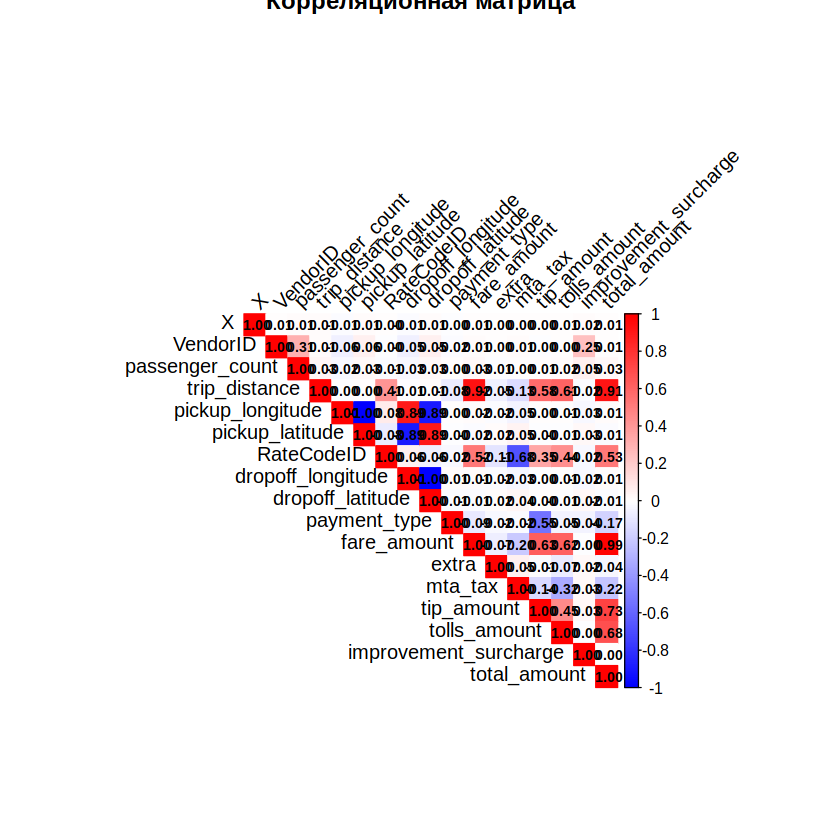

In [17]:
# Расчет корреляционной матрицы
correlation_matrix <- cor(numeric_columns)

# Визуализация корреляционной матрицы
library(corrplot)
corrplot(correlation_matrix, method = "color", type = "upper", tl.col = "black", 
         tl.srt = 45, col = colorRampPalette(c("blue", "white", "red"))(200), 
         addCoef.col = "black", number.cex = 0.7, title = "Корреляционная матрица")

# Функция для расчета VIF для всех переменных в наборе данных
calculate_vif <- function(data) {
  vif_data <- data.frame(
    feature = colnames(data),
    VIF = sapply(1:ncol(data), function(i) {
      # Модель линейной регрессии для каждой переменной как зависимой
      dependent_var <- data[, i]
      independent_vars <- data[, -i, drop = FALSE]
      
      # Формируем регрессионную модель
      model <- lm(dependent_var ~ ., data = as.data.frame(independent_vars))
      
      # Расчет R^2
      r_squared <- summary(model)$r.squared
      
      # Расчет VIF
      1 / (1 - r_squared)
    })
  )
  
  return(vif_data)
}


vif_result <- calculate_vif(numeric_columns)

cat("Фактор инфляции дисперсии (VIF):\n")
print(vif_result)

#### 5 Задание
Исследовать зависимости в данных с помощью дисперсионного
анализа.

In [18]:
data <- trips_per_day

group_1 <- trips_per_day %>%
  filter(X <= 14) %>%
  pull(trip_count)

group_2 <- trips_per_day %>%
  filter(X > 14) %>%
  pull(trip_count)

groups <- list(group_1, group_2)

# Однофакторный дисперсионный анализ (ANOVA)
anova_result <- aov(trip_count ~ I(X <= 14), data = data)

cat("\nРезультаты ANOVA:\n")
anova_summary <- summary(anova_result)
cat(sprintf("F-statistic: %.2f, p-value: %.4f\n", anova_summary[[1]]$`F value`[1], anova_summary[[1]]$`Pr(>F)`[1]))

if (anova_summary[[1]]$`Pr(>F)`[1] < 0.05) {
  cat("Значимые различия между группами по trip_count.\n")
} else {
  cat("Нет значимых различий между группами по trip_count.\n")
}

# Многофакторный ANOVA
formula <- fare_amount ~ VendorID + payment_type
anova_model <- aov(formula, data = df)

cat("\nМногофакторный ANOVA:\n")
print(summary(anova_model))


Результаты ANOVA:
F-statistic: 0.23, p-value: 0.6324
Нет значимых различий между группами по trip_count.

Многофакторный ANOVA:
               Df  Sum Sq Mean Sq F value Pr(>F)    
VendorID        1     132     132   1.314  0.252    
payment_type    1    7426    7426  74.107 <2e-16 ***
Residuals    9997 1001731     100                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [19]:
groups <- split(df_2$Heart_Rate, df_2$Health_Risk_Level)

# Тест Колмогорова-Смирнова на нормальность
ks_test <- ks.test(
  df_2$Heart_Rate,
  "pnorm",
  mean = mean(df_2$Heart_Rate, na.rm = TRUE),
  sd = sd(df_2$Heart_Rate, na.rm = TRUE)
)

cat("Kolmogorov-Smirnov test:\n")
cat(sprintf("Stat: %.2f, p-value: %.4f\n", ks_test$statistic, ks_test$p.value))

# Проверка значимости результата
if (ks_test$p.value < 0.05) {
  cat("Распределение Heart_Rate существенно отличается от нормального.\n")
} else {
  cat("Распределение Heart_Rate соответствует нормальному.\n")
}

# Однофакторный дисперсионный анализ (ANOVA)
anova_result <- aov(Heart_Rate ~ Health_Risk_Level, data = df_2)

cat("\nРезультаты ANOVA:\n")
anova_summary <- summary(anova_result)
cat(sprintf("F-statistic: %.2f, p-value: %.4f\n", 
            anova_summary[[1]]$`F value`[1], 
            anova_summary[[1]]$`Pr(>F)`[1]))

if (anova_summary[[1]]$`Pr(>F)`[1] < 0.05) {
  cat("Значимые различия между группами Health_Risk_Level по Heart_Rate.\n")
} else {
  cat("Нет значимых различий между группами Health_Risk_Level по Heart_Rate.\n")
}

# Многофакторный ANOVA
formula <- Heart_Rate ~ Mood + Sleep_Quality
anova_model <- aov(formula, data = df_2)

cat("\nМногофакторный ANOVA:\n")
print(summary(anova_model))

Kolmogorov-Smirnov test:
Stat: 0.02, p-value: 0.9161
Распределение Heart_Rate соответствует нормальному.

Результаты ANOVA:
F-statistic: 0.67, p-value: 0.5130
Нет значимых различий между группами Health_Risk_Level по Heart_Rate.

Многофакторный ANOVA:
               Df Sum Sq Mean Sq F value Pr(>F)
Mood            2     32   16.03   0.176  0.839
Sleep_Quality   2    251  125.29   1.374  0.254
Residuals     995  90727   91.18               
